In [1]:
pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00


# **TIỀN XỬ LÝ BỘ DỮ LIỆU**

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras. preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd. read_csv("/content/drive/MyDrive/Nhóm_3_BTL_Al/Data/Labeldata_btl.csv", encoding="UTF-8")
data.head(10)

,RevId,UserId,Comment,Rating,sentiment
0,2824877,786914,Gọi ship 1 xuất cari gà bánh naan và 3 miếng g...,5.8,Negative
1,2681764,118026,"Gà nướng ngon, mềm, không quá cay, không bị qu...",7.4,Positive
2,2366584,2144454,Cơm cari tôm và nấm nướng ship về. T ko rõ về ...,6.0,Negative
3,2047862,11119860,Everything is perfect. Friendly atmosphere and...,9.2,Positive
4,1903626,2030725,"Mình đi ăn vào trưa t5 nên khá vắng, có vẻ nhà...",8.4,Positive
5,11176798,2200003,"Mình rất khoái quán này, nhiều đồ HK vừa miệng...",7.8,Positive
6,9816702,22467889,"Thời tiết lạnh như này, cả nhà rủ nhau đến leg...",9.6,Positive
7,9813627,22466404,Hôm nay được anh chị trong công ty rủ đi ăn. Đ...,10.0,Positive
8,9813559,22466387,Trải nghiệm ẩm thực hongkong với nhà hàng le g...,9.6,Positive
9,9813486,22466366,Lâu lắm rồi mình mới được nếm lại hương vị hon...,9.8,Positive


In [5]:
# tổng quan về dữ liệu
data.info()
print('Thống kê mô tả các cột')
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36021 entries, 0 to 36020
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RevId      36021 non-null  object 
 1   UserId     36021 non-null  object 
 2   Comment    36020 non-null  object 
 3   Rating     36011 non-null  float64
 4   sentiment  36021 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.4+ MB
Thống kê mô tả các cột


,Rating
count,36011.000000
mean,6.999656
std,2.330025
min,0.000000
25%,6.200000
50%,7.400000
75%,8.600000
max,10.000000


In [6]:
# kiểm tra dữ liệu thiếu
missing_values = data.isnull().sum()
print(f"Dữ liệu thiếu ở mỗi cột:\n{missing_values}")

Dữ liệu thiếu ở mỗi cột:
RevId         0
UserId        0
Comment       1
Rating       10
sentiment     0
dtype: int64


In [7]:
# loại bỏ hàng có giá trị khuyết thiếu
data.dropna(inplace=True)

In [8]:
# kiểm tra và xử lý dữ liệu trùng lặp
duplicate_rows = data.duplicated()
print(f"Số hàng trùng lặp: {duplicate_rows.sum()}")

Số hàng trùng lặp: 0


In [9]:
# Xóa cột "RevId" and "UserId"
data = data.drop(columns=['RevId', 'UserId'])
data.head(5)

,Comment,Rating,sentiment
0,Gọi ship 1 xuất cari gà bánh naan và 3 miếng g...,5.8,Negative
1,"Gà nướng ngon, mềm, không quá cay, không bị qu...",7.4,Positive
2,Cơm cari tôm và nấm nướng ship về. T ko rõ về ...,6.0,Negative
3,Everything is perfect. Friendly atmosphere and...,9.2,Positive
4,"Mình đi ăn vào trưa t5 nên khá vắng, có vẻ nhà...",8.4,Positive


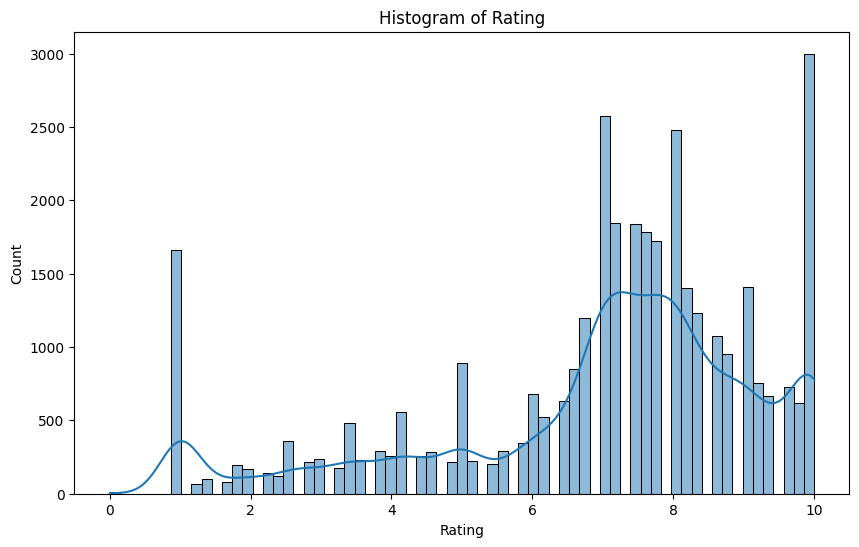

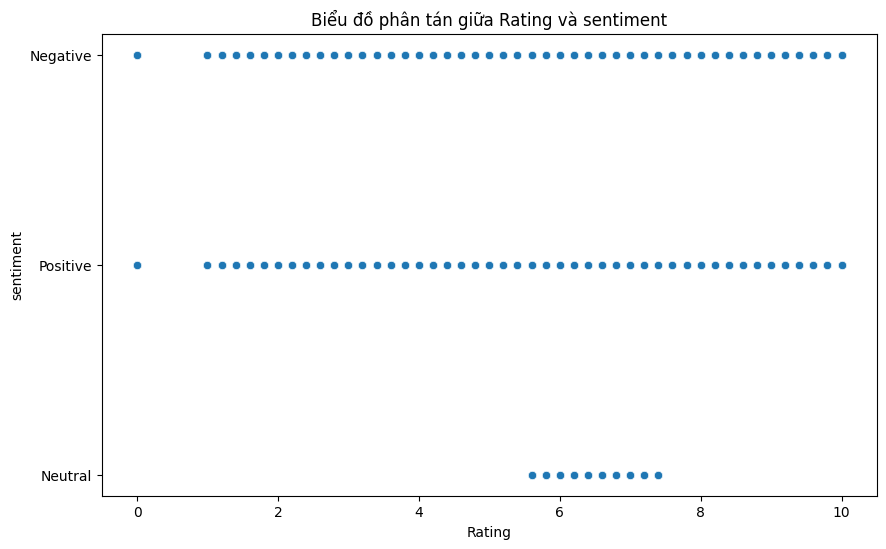

In [10]:
# Phân tích và trực quan hóa dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns

# Biểu đồ phân phối cho một cột
plt.figure(figsize=(10, 6))
sns.histplot(data['Rating'], kde=True)
plt.title('Histogram of Rating')
plt.show()

# Biểu đồ phân tán giữa hai cột
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Rating'], y=data['sentiment'])
plt.title('Biểu đồ phân tán giữa Rating và sentiment')
plt.show()

**TIỀN XỬ LÝ VĂN BẢN TRƯỚC KHI ĐƯA VÀO HUẤN LUYỆN MÔ HÌNH**

**Bước 1: Chuẩn bị dữ liệu và tiền xử lý văn bản**

In [11]:
input_data = data['Comment'].values
input_label = data['sentiment'].values
label_dict = {'Negative':0,'Positive':1, 'Neutral': 2}
input_pre = []
label_with_accent = []
for idx, dt in enumerate(input_data):

  #Chuyển đổi nhận xét thành chữ thường và chia nó thành một danh sách các từ.
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(str(dt)))
  #Nối danh sách các từ trở lại thành một chuỗi duy nhất.
  input_text_pre = " ".join(input_text_pre)
  #Xóa dấu trọng âm khỏi văn bản và giải mã nó trở lại chuỗi.
  input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
  #Mã hóa văn bản được nhấn mạnh bằng cách sử dụng .ViTokenizer
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  #Mã hóa văn bản không có dấu bằng cách sử dụng .ViTokenizer
  input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
  #Nối văn bản có dấu được mã hóa vào danh sách.input_pre
  input_pre.append(input_text_pre_accent)
  #Nối văn bản không dấu được mã hóa vào danh sách.input_pre
  input_pre.append(input_text_pre_no_accent)
  #Nối nhãn tương ứng thành hai lần (một lần cho mỗi phiên bản của văn bản).
  label_with_accent.append(input_label[idx])
  label_with_accent.append(input_label[idx])

In [12]:
negative_count = len(data[data['sentiment'] == 'Negative'])
print("Số lượng nhãn Negative là:", negative_count)

positive_count = len(data[data['sentiment'] == 'Positive'])
print("Số lượng nhãn Positive là:", positive_count)

Số lượng nhãn Negative là: 11968
Số lượng nhãn Positive là: 19814


**Bước 2: Mã hóa nhãn và xây dựng tokenizer**

In [13]:
# Chuyển đổi tokenizer bộ dữ liệu và lưu vào file
label_dict = {'Negative':0, 'Positive':1, 'Neutral': 2}
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3, dtype='float32')

# khởi tạo một đối tượng tokenizer_data từ lớp Tokenizer trong Keras để mã hóa
# và chuyển đổi dữ liệu văn bản thành chuỗi số nguyên.
tokenizer_data = Tokenizer(oov_token='<OOV>', filters = '', split = ' ')

# sử dụng phương thức fit_on_texts() của tokenizer_data để thực hiện mã hóa
# từ vựng và xây dựng từ điển từ dữ liệu input_pre. Điều này giúp xác định
# các từ duy nhất và gán một số nguyên duy nhất cho mỗi từ.
tokenizer_data.fit_on_texts(input_pre)

# sử dụng phương thức texts_to_sequences() của tokenizer_data để chuyển đổi
# dữ liệu văn bản input_pre thành các chuỗi số nguyên tương ứng với từng
# từ trong từ điển
tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)

# sử dụng hàm pad_sequences() để đệm các chuỗi số nguyên trong
# tokenizer_data_text thành cùng một độ dài (maxlen = 120).
# Điều này đảm bảo rằng các chuỗi đầu vào có cùng kích thước
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen = 120)

**Bước 3: Lưu trữ tokenizer và kiểm tra dữ liệu**

In [14]:
pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))
# Lưu model tokenizer_data.pkl vào đường dẫn /content/drive/My Drive/CD
with open("/content/drive/MyDrive/Nhóm_3_BTL_Al/tokenizer_data.pkl", "wb") as file:
    pickle.dump(tokenizer_data, file)

print("input data.shape", vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index)+1
print("data_vocab_size: ", data_vocab_size)

input data.shape (72022, 120)
data_vocab_size:  42865


# **XÂY DỰNG MÔ HÌNH**

In [15]:
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM
from keras.models import Model
from keras.optimizers import Adam

**CHIA DỮ LIỆU (Data Splitting)**

In [16]:
# Chia tập dữ liệu thành 3 phần train, val, test
X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(vec_data, label_tf, test_size=0.1, random_state=42)
print("Training sample: ", len(X_train))
print("Validation sample: ", len(X_val))
print("Test sample: ", len(X_test))

Training sample:  64819
Validation sample:  14405
Test sample:  7203


**TRÍCH CHỌN ĐẶC TRƯNG**

In [17]:
def generate_model():
  # khai báo ngưỡng dropout, đại diện cho tỷ lệ các đơn vị bị bỏ qua
  # trong quá trình huấn luyện để tránh việc quá khớp (overfitting)
  dropout_threshold = 0.3

  # gán kích thước của từ điển từ dữ liệu cho biến input_dim
  input_dim = data_vocab_size

  # gán kích thước đầu ra của lớp nhúng (embedding) cho biến output_dim.
  # Trong trường hợp này, các từ sẽ được biểu diễn bằng một vector 32 chiều.
  output_dim = 32

  # gán độ dài đầu vào cho biến input_length. đảm bảo rằng độ dài của các chuỗi
  # đầu vào sẽ được đệm (padding) hoặc cắt (truncation) để có cùng kích thước
  input_length = 120
# khởi tạo một đối tượng GlorotNormal từ module initializers trong
  # thư viện Keras để sử dụng làm trình khởi tạo trọng số cho mạng nơ-ron.
  initializer = tf.keras.initializers.GlorotNormal()

  # khai báo lớp đầu vào với kích thước đầu vào là input_length
  input_layer = Input(shape=input_length)

  # thực hiện lớp nhúng (embedding) ánh xạ các từ sang các vector dựa trên
  # input_dim và output_dim. embeddings_initializer được sử dụng để khởi tạo
  # ma trận trọng số của lớp nhúng
  feature = Embedding(input_dim=input_dim, output_dim=output_dim,
                      input_length=input_length,
                      embeddings_initializer="GlorotNormal")(input_layer)

  # Sử dụng mạng nơ ron tích chập trích xuất các đặc trưng từ đầu vào đã nhúng.
  # Các lớp này được sử dụng để tạo một đặc trưng từ ngữ cảnh và cấu trúc của câu
  cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same',
                       activation='relu')(feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)
  cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = LayerNormalization()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)

  # chuỗi các lớp LSTM hai chiều (Bidirectional LSTM) để trích xuất
  # các đặc trưng từ các chuỗi đầu vào. Lớp này giúp mô hình có khả năng học
  # được các phụ thuộc dài hạn trong dữ liệu chuỗi.
  bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold,
                                       return_sequences=True,
                                       kernel_initializer=initializer),
                                  merge_mode = 'concat')(feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

  bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold,
                                       return_sequences=True,
                                       kernel_initializer=initializer),
                                  merge_mode = 'concat')(bi_lstm_feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
  bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

  # kết hợp hai tập đặc trưng từ các lớp tích chập và LSTM thành
  # một tập đặc trưng duy nhất bằng cách kết hợp chúng theo chiều thứ hai.
  combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
  combine_feature = GlobalMaxPooling1D()(combine_feature)
  combine_feature = LayerNormalization()(combine_feature)

  # chuỗi các lớp mạng nơ-ron tiếp theo để xử lý tập đặc trưng đã kết hợp.
  # Các lớp này thực hiện các phép biến đổi phi tuyến để tạo ra dự đoán cuối cùng.
  classifier = Dense(90, activation = 'relu')(combine_feature)
  classifier = Dropout(0.3)(classifier)
  classifier = Dense(70, activation = 'relu')(classifier)
  classifier = Dropout(0.3)(classifier)
  classifier = Dense(50, activation = 'relu')(classifier)
  classifier = Dropout(0.3)(classifier)
  classifier = Dense(30, activation = 'relu')(classifier)
  classifier = Dropout(0.3)(classifier)
  classifier = Dense(3, activation = 'softmax')(classifier)

  model = tf.keras.Model(inputs = input_layer, outputs= classifier)

  return model

model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 120, 32)              1371680   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 120, 32)              3104      ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 60, 32)               0         ['conv1d[0][0]']              
 D)                                                                                           

**HUẤN LUYỆN MÔ HÌNH**

In [18]:
# Huấn luyện mô hình sử dụng mạng CNN-BiLSTM trên dữ liệu huấn luyện và dữ liệu kiểm tra (validation)

callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.keras', monitor='val_loss')
history = model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val), epochs = 15, batch_size = 128, callbacks=[callback_model])

Epoch 1/15
507/507 [==============================] - 191s 351ms/step - loss: 0.8825 - accuracy: 0.6024 - val_loss: 0.6272 - val_accuracy: 0.7511
Epoch 2/15
507/507 [==============================] - 178s 351ms/step - loss: 0.6341 - accuracy: 0.7632 - val_loss: 0.5502 - val_accuracy: 0.7854
Epoch 3/15
507/507 [==============================] - 187s 368ms/step - loss: 0.5566 - accuracy: 0.7881 - val_loss: 0.5347 - val_accuracy: 0.7938
Epoch 4/15
507/507 [==============================] - 190s 374ms/step - loss: 0.5032 - accuracy: 0.8043 - val_loss: 0.4969 - val_accuracy: 0.8016
Epoch 5/15
507/507 [==============================] - 178s 351ms/step - loss: 0.4609 - accuracy: 0.8150 - val_loss: 0.4926 - val_accuracy: 0.8050
Epoch 6/15
507/507 [==============================] - 177s 349ms/step - loss: 0.4209 - accuracy: 0.8276 - val_loss: 0.4704 - val_accuracy: 0.8131
Epoch 7/15
507/507 [==============================] - 190s 375ms/step - loss: 0.3924 - accuracy: 0.8426 - val_loss: 0.4678 -

In [19]:
# Kiểm tra độ chính xác của mô hình trên tập test
model.load_weights("model_cnn_bilstm.keras")
model.evaluate(X_test,y_test)

226/226 [==============================] - 9s 40ms/step - loss: 0.8548 - accuracy: 0.7773


[0.854771077632904, 0.7773150205612183]

In [20]:
labels = ["Neutral","Negative","Positive"]

y_pred = model.predict(X_val)  # Dự đoán trên tập validation

451/451 [==============================] - 23s 45ms/step


In [21]:
import numpy as np

y_pred = [labels[np.argmax(pred)] for pred in y_pred]
y_true = [labels[np.argmax(true)] for true in y_val]  # Nhãn thực tế trên tập validation

**HIỆU SUẤT MÔ HÌNH**

In [22]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, zero_division=1)
print(report)

              precision    recall  f1-score   support

    Negative       0.88      0.93      0.91      7949
     Neutral       0.90      0.86      0.87      4768
    Positive       0.63      0.56      0.59      1688

    accuracy                           0.86     14405
   macro avg       0.80      0.78      0.79     14405
weighted avg       0.86      0.86      0.86     14405



**KIỂM THỬ**

**Dự đoán cảm xúc từ một câu văn đầu vào bằng cách sử dụng mô hình đã huấn luyện**



*   **Bước 1: Chuẩn hóa câu văn đầu vào bằng cách loại bỏ các ký tự đặc biệt và chuyển thành chuỗi các từ.**



In [23]:
def preprocess_raw_input(raw_input, tokenizer):
  # Tiền xử lý câu văn đầu vào
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
  input_text_pre = " ".join(input_text_pre)
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  print("Text preprocessed: ", input_text_pre_accent)

  # Chuyển đổi câu văn thành vector số hóa thích hợp cho mô hình
  tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
  vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=120)
  return vec_data

- **Bước 2: Dự đoán đầu ra từ mô hình**

In [24]:
def inference_model(input_feature, model):
  # Dự đoán đầu ra từ mô hình
  output = model(input_feature).numpy()[0]
  result = output.argmax()  # Lấy chỉ số của lớp có xác suất cao nhất
  conf = float(output.max()) # Xác suất cao nhất
  label_dict = {'Negative':0, 'Positive': 1, 'Neutral':2}
  label = list(label_dict.keys())
  return label[int(result)], conf


* **Bước 3: Dự đoán cảm xúc từ câu văn đã được tiền xử lý bằng cách gọi hàm inference_model.**



In [25]:
def prediction(raw_input, tokenizer, model):
  input_model = preprocess_raw_input(raw_input, tokenizer_data)
  result, conf = inference_model(input_model, model)

    # Kiểm tra điều kiện cho câu phủ định
  if "không" in raw_input and result != 'Neutral':
        if result == 'Positive':
            result = 'Negative'
        elif result == 'Negative':
            result = 'Positive'
  return result, conf

  **Bước 4: Sử dụng các hàm để dự đoán cảm xúc của một câu văn**

In [26]:
my_model = generate_model()
my_model = load_model('model_cnn_bilstm.keras')

with open(r"tokenizer_data.pkl", "rb") as input_file:
  my_tokenizer = pickle.load(input_file)

print(prediction("Đồ ăn không ngon", my_tokenizer, my_model))

Text preprocessed:  đồ ăn_không ngon
('Negative', 0.846522867679596)


In [27]:
# vòng lặp vô hạn để kiểm thử mô hình phân loại dựa vào đầu vào từ
# người dùng qua dòng lệnh. Người dùng sẽ nhập các đoạn văn bản để mô hình
# dự đoán lớp (sentiment) tương ứng cho mỗi đoạn văn bản đó.
# Người dùng có thể nhập "end" để kết thúc vòng lặp và thoát khỏi chương trình
while(True):
  text = input()
  if text == "end":
    break

  else:
    print(prediction(text, my_tokenizer, my_model)[0] + "\n")

Đồ ăn rất ngon
Text preprocessed:  đồ ăn rất ngon
Positive

Thái độ phục vụ tệ
Text preprocessed:  thái_độ phục_vụ tệ
Negative

end


# **ĐÁNH GIÁ MÔ HÌNH**

**THAY ĐỔI THAM SỐ**

In [28]:
# Tăng số lượng epochs và giảm batch size
epochs = 20
batch_size = 64

# Thay đổi learning rate
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)

# Cấu hình mô hình
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm_best_manual.keras', monitor='val_loss', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Huấn luyện mô hình
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[callback_model, early_stopping])

# Đánh giá trên tập test
model.load_weights('model_cnn_bilstm_best_manual.keras')
model.evaluate(X_test, y_test)

Epoch 1/20
1013/1013 [==============================] - 257s 242ms/step - loss: 0.1927 - accuracy: 0.9321 - val_loss: 0.5523 - val_accuracy: 0.8669
Epoch 2/20
1013/1013 [==============================] - 252s 249ms/step - loss: 0.1784 - accuracy: 0.9380 - val_loss: 0.5787 - val_accuracy: 0.8680
Epoch 3/20
1013/1013 [==============================] - 251s 248ms/step - loss: 0.1687 - accuracy: 0.9414 - val_loss: 0.5684 - val_accuracy: 0.8714
Epoch 4/20
226/226 [==============================] - 10s 46ms/step - loss: 0.9663 - accuracy: 0.7812


[0.9662545919418335, 0.7812022566795349]

In [29]:
labels = ["Neutral","Negative","Positive"]

y_pred = model.predict(X_val)  # Dự đoán trên tập validation

import numpy as np

y_pred = [labels[np.argmax(pred)] for pred in y_pred]
y_true = [labels[np.argmax(true)] for true in y_val]  # Nhãn thực tế trên tập validation

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, zero_division=1)
print(report)

451/451 [==============================] - 20s 40ms/step
              precision    recall  f1-score   support

    Negative       0.89      0.93      0.91      7949
     Neutral       0.89      0.87      0.88      4768
    Positive       0.64      0.58      0.61      1688

    accuracy                           0.87     14405
   macro avg       0.81      0.79      0.80     14405
weighted avg       0.86      0.87      0.87     14405



**THAY ĐỔI THUẬT TOÁN**

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import pickle

In [31]:
input_data = data['Comment'].values
input_label = data['sentiment'].values

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(input_data, input_label, test_size=0.2, random_state=42)

In [32]:
# Sử dụng CountVectorizer để chuyển đổi văn bản thành ma trận số lượng từ
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Lưu vectorizer để sử dụng trong tương lai
with open("vectorizer.pkl", "wb") as file:
    pickle.dump(vectorizer, file)

In [33]:
# Huấn luyện mô hình MultinomialNB
model = MultinomialNB()
model.fit(X_train_counts, y_train)

# Lưu mô hình
with open("model_nb.pkl", "wb") as file:
    pickle.dump(model, file)

In [34]:
# Đánh giá mô hình trên tập kiểm tra
y_pred = model.predict(X_test_counts)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

Accuracy: 70.91%
              precision    recall  f1-score   support

    Negative       0.69      0.72      0.70      2376
     Neutral       0.33      0.19      0.24       872
    Positive       0.77      0.82      0.79      3955

    accuracy                           0.71      7203
   macro avg       0.59      0.57      0.58      7203
weighted avg       0.69      0.71      0.70      7203



In [35]:
import re
import pickle

def preprocess_raw_input(raw_input, vectorizer):
    # Chuyển đổi văn bản thành ma trận số lượng từ
    tokenized_data_text = vectorizer.transform([raw_input])
    return tokenized_data_text

def inference_model(input_feature, model):
    # Use the predict_proba method to get probabilities for each class
    output = model.predict_proba(input_feature)[0]
    result = output.argmax()
    conf = float(output.max())
    label_dict = {0: 'Negative', 2: 'Positive', 1: 'Neutral'}
    return label_dict[int(result)], conf

def prediction(raw_input, vectorizer, model):
    input_model = preprocess_raw_input(raw_input, vectorizer)
    result, conf = inference_model(input_model, model)

    # Kiểm tra câu phủ định
    negation_words = ["không", "chẳng", "không được", "không bao giờ", "đừng", "đừng có", "đừng thế", "đừng bao giờ"]
    negation_pattern = r'\b(?:{})\b'.format('|'.join(negation_words))

    # Sử dụng biểu thức chính quy để kiểm tra xem câu có chứa từ phủ định hay không
    if re.search(negation_pattern, raw_input, flags=re.IGNORECASE) and result != 'Neutral':
        if result == 'Positive':
            result = 'Negative'
        elif result == 'Negative':
            result = 'Positive'

    return result, conf

# Tải vectorizer và mô hình
with open("vectorizer.pkl", "rb") as file:
    vectorizer = pickle.load(file)
with open("model_nb.pkl", "rb") as file:
    model = pickle.load(file)

# Dự đoán với văn bản mới
text_to_predict = "Đồ ăn không ngon"
predicted_label, confidence = prediction(text_to_predict, vectorizer, model)
print(f"Predicted label: {predicted_label}, Confidence: {confidence:.2f}")

Predicted label: Negative, Confidence: 0.77
